In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
#数据集读取
wine_datas = ['data/d2/winemag-data_first150k.csv','data/d2/winemag-data-130k-v2.csv']
data = pd.read_csv(wine_datas[0])
data.rename(columns={'Unnamed: 0':'id'}, inplace = True)
#数据初步查看
data.head(5)

,id,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
id             150930 non-null int64
country        150925 non-null object
description    150930 non-null object
designation    105195 non-null object
points         150930 non-null int64
price          137235 non-null float64
province       150925 non-null object
region_1       125870 non-null object
region_2       60953 non-null object
variety        150930 non-null object
winery         150930 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


## 1.数据摘要和可视化

### 数据摘要 

In [3]:
#标称属性取值频数统计,由于description是评论属性，因此不对此列进行计算
nominal_cols = ['country','designation','province','region_1','region_2','variety','winery']
for c in nominal_cols:
    print('***********************%s************************'%c)
    print(data[c].value_counts())
    print('\n')

***********************country************************
US                        62397
Italy                     23478
France                    21098
Spain                      8268
Chile                      5816
Argentina                  5631
Portugal                   5322
Australia                  4957
New Zealand                3320
Austria                    3057
Germany                    2452
South Africa               2258
Greece                      884
Israel                      630
Hungary                     231
Canada                      196
Romania                     139
Slovenia                     94
Uruguay                      92
Croatia                      89
Bulgaria                     77
Moldova                      71
Mexico                       63
Turkey                       52
Georgia                      43
Lebanon                      37
Cyprus                       31
Brazil                       25
Macedonia                    16
Serbia           

In [4]:
#数值属性的非空值、均值、标准差、最小值、4分位数、最大值
data.describe()

,id,points,price
count,150930.000000,150930.000000,137235.000000
mean,75464.500000,87.888418,33.131482
std,43569.882402,3.222392,36.322536
min,0.000000,80.000000,4.000000
25%,37732.250000,86.000000,16.000000
50%,75464.500000,88.000000,24.000000
75%,113196.750000,90.000000,40.000000
max,150929.000000,100.000000,2300.000000


In [16]:
#数值属性缺失值个数
points_nan = len(data)-data.count(numeric_only=True)[1]
price_nan = len(data)-data.count(numeric_only=True)[2]
print('points has',points_nan,'na value..')
print('price has',price_nan,'na value...')

points has 0 na value..
price has 13695 na value...


### 数据可视化

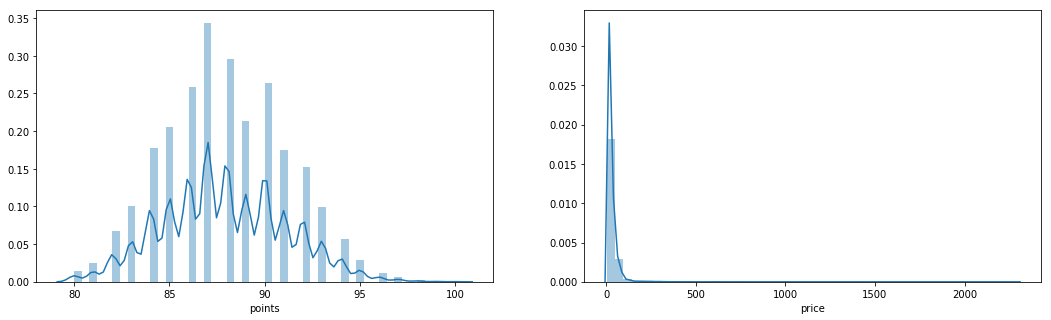

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#直方图
fig, axes = plt.subplots(1,2, figsize=(18, 5))
sns.distplot(data['points'][data['points'].notna()], ax = axes[0], kde = True)        # kde 密度曲线  
sns.distplot(data['price'][data['price'].notna()], ax = axes[1], kde = True)
plt.show() 

<Figure size 432x288 with 0 Axes>

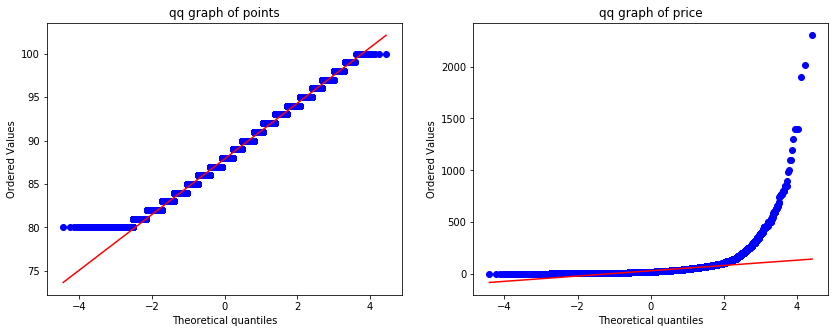

In [7]:
from scipy import stats
#QQ图
fig = plt.figure()
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(14,5))
stats.probplot(data['points'][data['points'].notna()], dist="norm", plot=ax1)
stats.probplot(data['price'][data['price'].notna()], dist="norm", plot=ax2)
ax1.set_title('qq graph of points')
ax2.set_title('qq graph of price')
plt.show()

可以发现，points属性的直方图和KDE曲线都接近正态分布，通过qq图也可以看出来它的分布和正态分布拟合的较好。
而price属性大量集中在较小的位置，并不符合正态分布。

<Figure size 432x288 with 0 Axes>

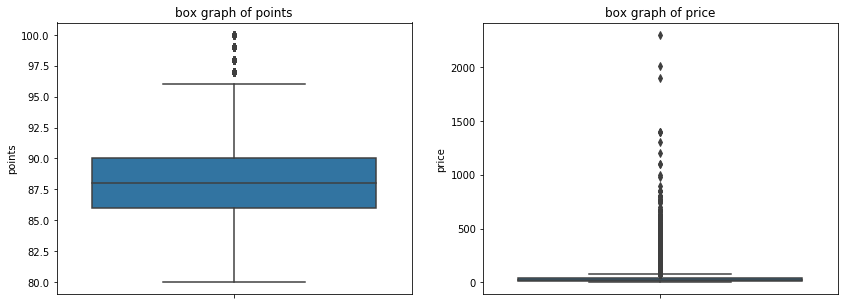

In [8]:
#盒图
fig = plt.figure()
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(14,5))
sns.boxplot(y=data['points'],ax=ax1)  
sns.boxplot(y=data['price'],ax=ax2)
ax1.set_title('box graph of points')
ax2.set_title('box graph of price')
plt.show()

由盒图可以看到，points属性数值较为集中，离群点较少，而price属性大部分点在100以下，离群点很多（可能有奢侈品酒类）

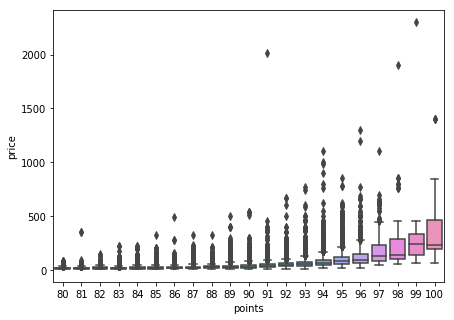

In [9]:
fig = plt.figure(figsize=(7,5))
sns.boxplot(x = data['points'],y=data['price'])
plt.show()

以用户打分points作为横坐标，价格price作为纵坐标画盒图，发现评价越高的价格离群点越少（价格越集中），与常识相符

## 2.数据缺失的处理

In [17]:
#观察缺失数据
lack_cols=['country','designation','price','province','region_1','region_2']
for c in lack_cols:
    num = data.shape[0]-data[c].count()
    print('%s has'%c,num,'na value...')

country has 5 na value...
designation has 45735 na value...
price has 13695 na value...
province has 5 na value...
region_1 has 25060 na value...
region_2 has 89977 na value...


发现有6列数据存在不同程度的缺失值，其中country、province缺失值极少，可以直接丢弃。比较重要的数值属性price缺失较多，因此需要进行处理
关于数据缺失的原因，可能是数据集作者进行爬虫时程序bug所致，或者数据源本身就没有这些缺失数据

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
id             150930 non-null int64
country        150925 non-null object
description    150930 non-null object
designation    105195 non-null object
points         150930 non-null int64
price          137235 non-null float64
province       150925 non-null object
region_1       125870 non-null object
region_2       60953 non-null object
variety        150930 non-null object
winery         150930 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


### 2.1将缺失值剔除

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39241 entries, 0 to 150916
Data columns (total 11 columns):
id             39241 non-null int64
country        39241 non-null object
description    39241 non-null object
designation    39241 non-null object
points         39241 non-null int64
price          39241 non-null float64
province       39241 non-null object
region_1       39241 non-null object
region_2       39241 non-null object
variety        39241 non-null object
winery         39241 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 3.6+ MB


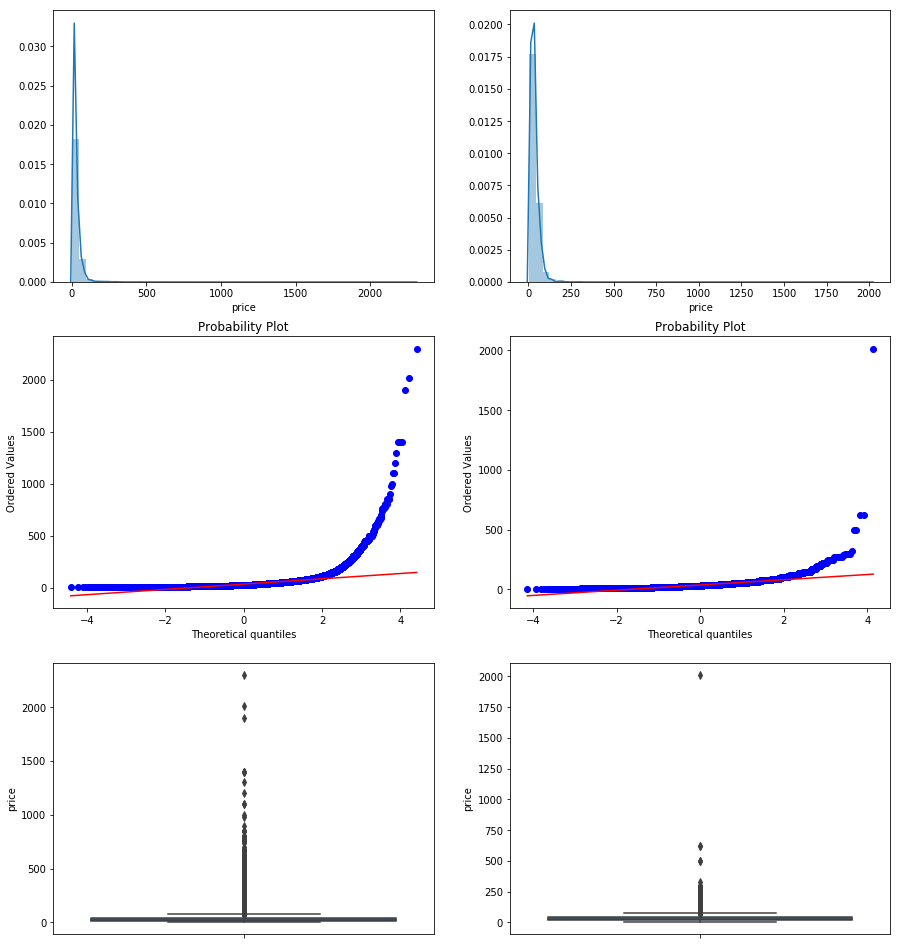

In [12]:
#直方图
drop_1 = data.dropna(axis=0)
drop_1.info()
fig, axes = plt.subplots(3,2, figsize=(15, 17))
sns.distplot(data['price'][data['price'].notna()], ax = axes[0,0], kde = True)        # kde 密度曲线  
sns.distplot(drop_1['price'], ax = axes[0,1], kde = True)
#QQ图
stats.probplot(data['price'][data['price'].notna()], dist="norm", plot=axes[1,0])
stats.probplot(drop_1['price'], dist="norm", plot=axes[1,1])
#盒图
sns.boxplot(y=data['price'],ax=axes[2,0])  
sns.boxplot(y=drop_1['price'],ax=axes[2,1])
plt.show()

左边一列是去除缺失值之前的数据，右边一列是丢弃缺失值之后的数据分布，从上到下分别是直方图、QQ图、盒图，可以看到去除缺失值数据之后数据的分布明显更接近正态分布，而且离群点变少了

### 2.2 用最高频率值填补缺失值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
id             150930 non-null int64
country        150930 non-null object
description    150930 non-null object
designation    150930 non-null object
points         150930 non-null int64
price          150930 non-null float64
province       150930 non-null object
region_1       150930 non-null object
region_2       150930 non-null object
variety        150930 non-null object
winery         150930 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


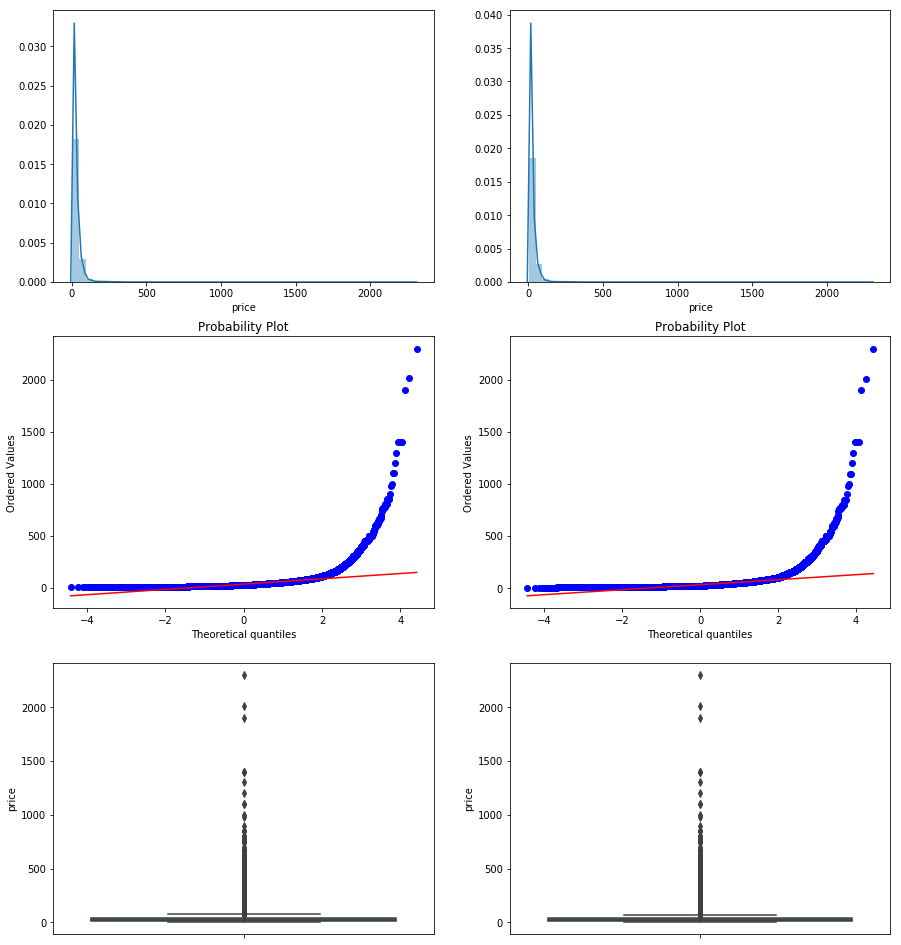

In [13]:
drop_2 = data.fillna(data.mode().iloc[0])
drop_2.info()
fig, axes = plt.subplots(3,2, figsize=(15, 17))
sns.distplot(data['price'][data['price'].notna()], ax = axes[0,0], kde = True)        # kde 密度曲线  
sns.distplot(drop_2['price'], ax = axes[0,1], kde = True)
#QQ图
stats.probplot(data['price'][data['price'].notna()], dist="norm", plot=axes[1,0])
stats.probplot(drop_2['price'], dist="norm", plot=axes[1,1])
#盒图
sns.boxplot(y=data['price'],ax=axes[2,0])  
sns.boxplot(y=drop_2['price'],ax=axes[2,1])
plt.show()

用众数填充缺失值之后并没有很大变化

after filling, price has 150930 data, total 150930 data


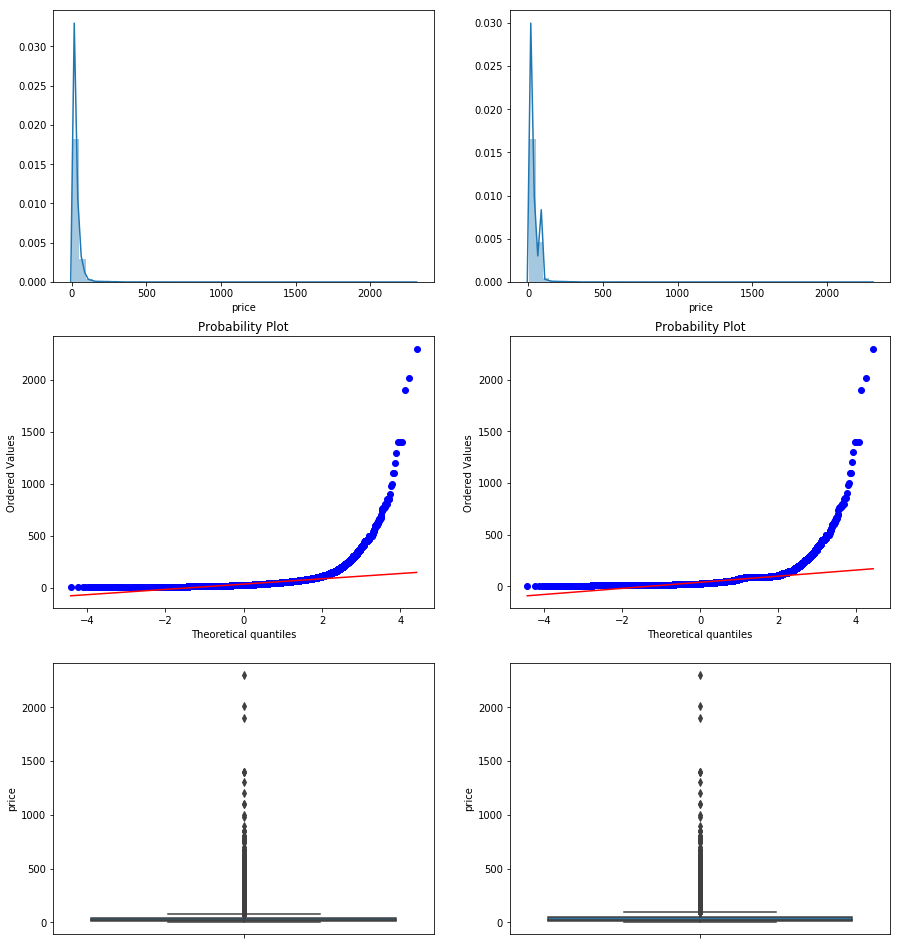

In [14]:
# 3.通过属性的相关关系来填补缺失
from sklearn.linear_model import LinearRegression
def linear_missing_filling(x_train,y_train,test):
    clf = LinearRegression()
    clf.fit(x_train,y_train)
    return clf.predict(test)
x_points = np.array(drop_1['points']).reshape(-1,1)
y_price = np.array(drop_1['price']).reshape(-1,1)
price_data = np.array(data['points']).reshape(-1,1)
linear_missing_filling(x_points,y_price,price_data)
drop_3 = data.copy()
drop_3.loc[drop_3['price'].isnull(),'price']=price_data[drop_3['price'].isnull()]
print('after filling, price has',drop_3['price'].count(),'data, total %d data'%drop_3.shape[0])
fig, axes = plt.subplots(3,2, figsize=(15, 17))
sns.distplot(data['price'][data['price'].notna()], ax = axes[0,0], kde = True)        # kde 密度曲线  
sns.distplot(drop_3['price'], ax = axes[0,1], kde = True)
#QQ图
stats.probplot(data['price'][data['price'].notna()], dist="norm", plot=axes[1,0])
stats.probplot(drop_3['price'], dist="norm", plot=axes[1,1])
#盒图
sns.boxplot(y=data['price'],ax=axes[2,0])  
sns.boxplot(y=drop_3['price'],ax=axes[2,1])
plt.show()

使用数据集其他属性作为x_train，建立线性回归模型预测price的缺失值，并填充回表里。通过柱形图可以看出来填充的值基本都在100左右，因此对整体分布和离群点影响不大

after filling, price has 150930 data, total 150930 data


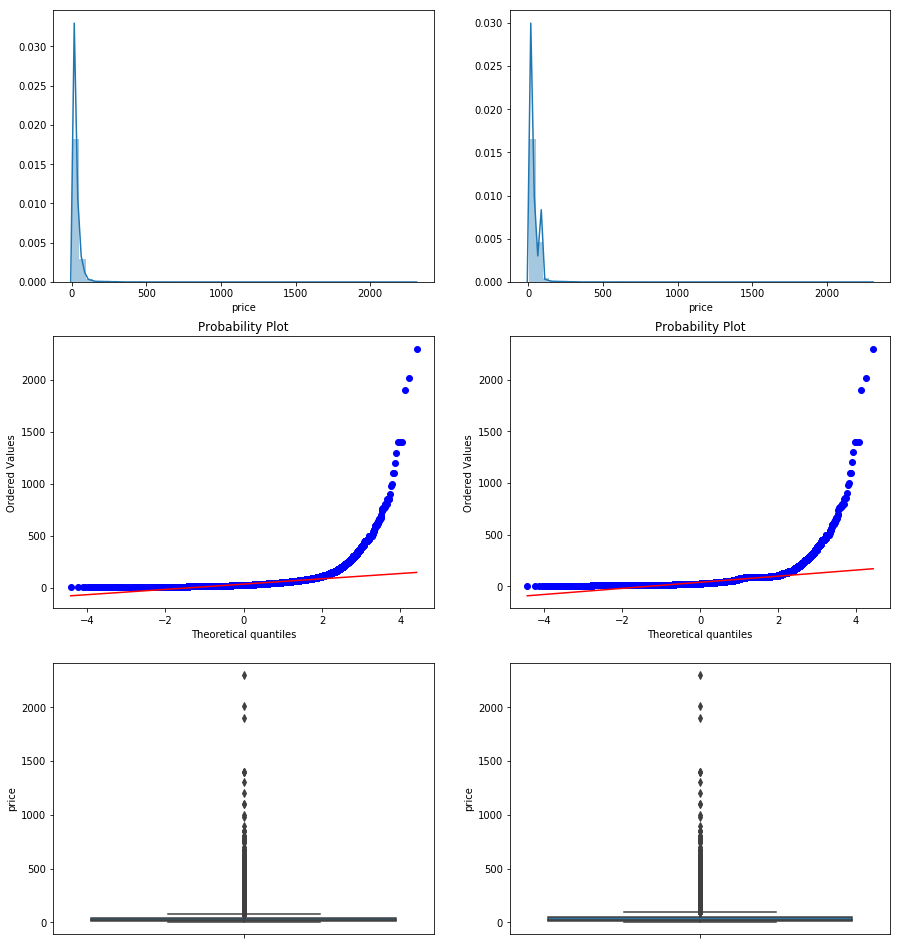

In [15]:
# 4.通过数据对象之间的相似性来填补缺失值
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
def knn_missing_filling(x_train,y_train,test,k=5,classifier=False):
    if classifier:
        clf = KNeighborsClassifier(n_neighbors=k,weights='distance')
    else:
        clf = KNeighborsRegressor(n_neighbors=k,weights='distance')
    clf.fit(x_train,y_train)
    return clf.predict(test)
x_points = np.array(drop_1['points']).reshape(-1,1)
y_price = np.array(drop_1['price']).reshape(-1,1)
price_data = np.array(data['points']).reshape(-1,1)
knn_missing_filling(x_points,y_price,price_data)
drop_4 = data.copy()
drop_4.loc[drop_4['price'].isnull(),'price']=price_data[drop_4['price'].isnull()]
print('after filling, price has',drop_4['price'].count(),'data, total %d data'%drop_4.shape[0])
fig, axes = plt.subplots(3,2, figsize=(15, 17))
sns.distplot(data['price'][data['price'].notna()], ax = axes[0,0], kde = True)        # kde 密度曲线  
sns.distplot(drop_4['price'], ax = axes[0,1], kde = True)
#QQ图
stats.probplot(data['price'][data['price'].notna()], dist="norm", plot=axes[1,0])
stats.probplot(drop_4['price'], dist="norm", plot=axes[1,1])
#盒图
sns.boxplot(y=data['price'],ax=axes[2,0])  
sns.boxplot(y=drop_4['price'],ax=axes[2,1])
plt.show()

使用sklearn进行KNN计算，使用距离最近的K个数据的平均或加权投票得到缺失值的填充,由于本数据集只有points一个非空数值属性，因此只能用这一列做KNN的
x_train，来预测缺失的price，并填充到表里。